# ControlNet으로 조건을 준 이미지 생성하기
- ControlNet은 외곽선 감지(Canny Edge detection), 인체 자세 감지(Human pose), 낙서 지도(Scribble map), 시맨틱 세그멘테이션(Semantic segmentation) 등 다양한 전처리기(Preprocessor)를 Stable Diffusion 모델에 도입하여 그래서 원하는 자세, 구도 등으로 이미지를 생성할 수 있다.
- ontrolNet을 사용하여 이미지를 어떻게 제어해본다.

In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

In [ ]:
# 메모리 삭제
import torch
torch.cuda.empty_cache()

CUDA out of memery 문제 발생 시 메모리 삭제를 진행해준다.

# 1. 윤곽선 검출
- 효과적인 운곽선 검출 알고리즘인 Canny 알고리즘을 사용하여 윤곽선을 검출해본다.

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//10.88.0.1'

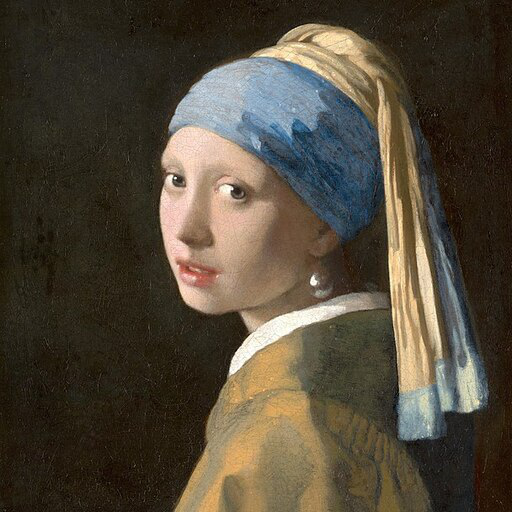

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 


# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

- openCV를 사용하여 이미지의 윤곽선을 검출한다.

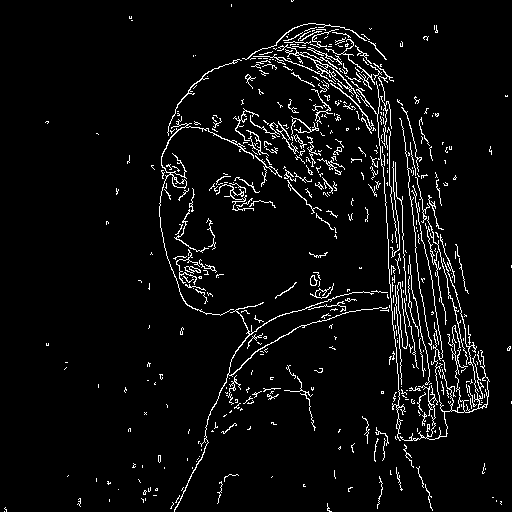

In [3]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환
image = np.array(image)

# threshold를 지정
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환

canny_image

- 윤곽선 검출 전처리기를 사용한 모델 파이프라인을 불러온다.

In [4]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


- 윤곽선을 추출한 이미지에 프롬프트를 적용하여 새로운 이미지를 생성해 본다.

  0%|          | 0/20 [00:00<?, ?it/s]

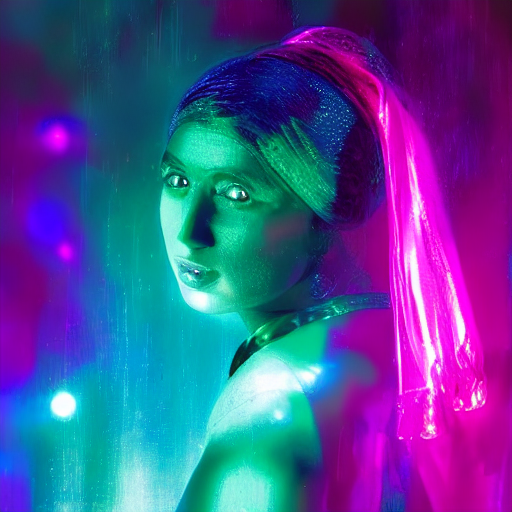

In [5]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

- 외에도 부정적인 프롬프트(negative_propmt)삽입 가능, 하이퍼파라미터를 조절 가능.

    - negative_propmt: 원하지 않는 요소
    - controlnet_conditioning_scale: ContorlNet으로 조건을 어느 정도 주느냐를 조절. Default는 1이고, 실수값으로 설정할 수 있다.
    - num_inference_steps: 추론 횟수, 값이 커질수록 고해상도 이미지가 출력. 출력되는 시간이 오래 걸린다. (default : 50)
    - guidance_scale: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있다. (default : 7.5)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

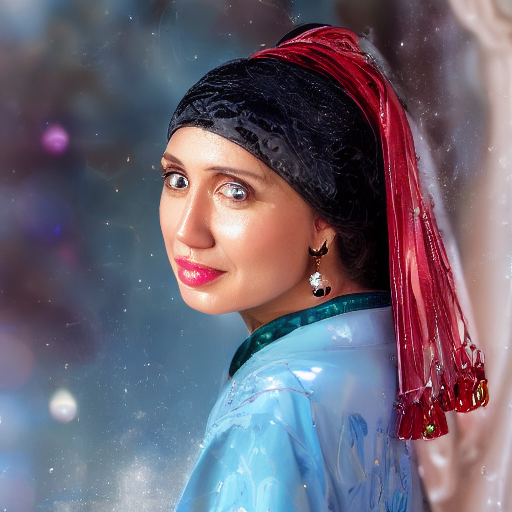

In [6]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
from diffusers import UniPCMultistepScheduler
import cv2
from PIL import Image
import numpy as np

# 이미지 로드
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# 이미지를 Canny 엣지 검출을 사용하여 처리합니다.
low_threshold = 100
high_threshold = 200
edges = cv2.Canny(image, low_threshold, high_threshold)
edges = edges[:, :, None]
edges = np.concatenate([edges, edges, edges], axis=2)
canny_image = Image.fromarray(edges)

# ControlNet 모델과 파이프라인을 불러옵니다.
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

# 스케줄러 설정
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 시드 설정
generator = torch.manual_seed(0)

# 이미지 생성
canny_image = canny_pipe(
    prompt="A fresh-faced girl and her sparkling earrings",
    negative_prompt="The girl's outline is vague",
    controlnet_conditioning_scale=1.2,
    num_inference_steps=20,
    guidance_scale=10.0,
    generator=generator,
    image=canny_image
).images[0]

# 이미지 저장
canny_image.save("/aiffel/aiffel/canny_image.png")

# 생성된 이미지 출력
canny_image.show()

# 2. 인체 자세 감지
- Human pose를 할수 있는 Openpose전처리기를 사용. 자세를 감지하여  새로운 이미지를 생성해본다.

In [7]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     |████████████████████████████████| 42 kB 1.4 MB/s             


- 전신이 담긴 이미지 불러옴

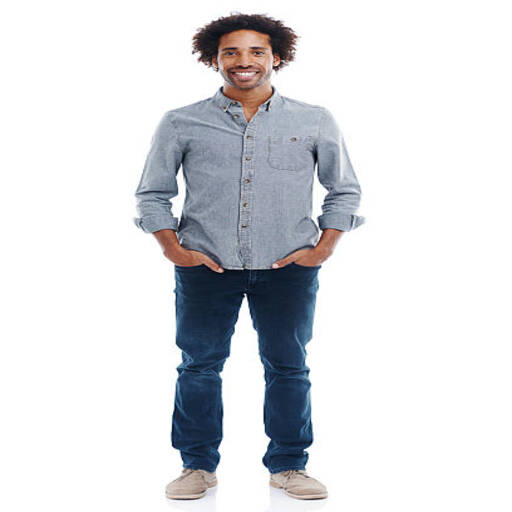

In [8]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

- Openpose 검출기를 사용하여 자세 추출

cuda


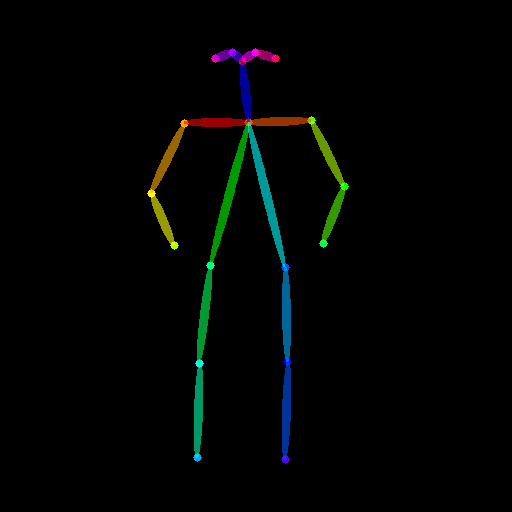

In [9]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

- Openpose 전처리기를 사용한 모델 파이프라인 호출

In [10]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

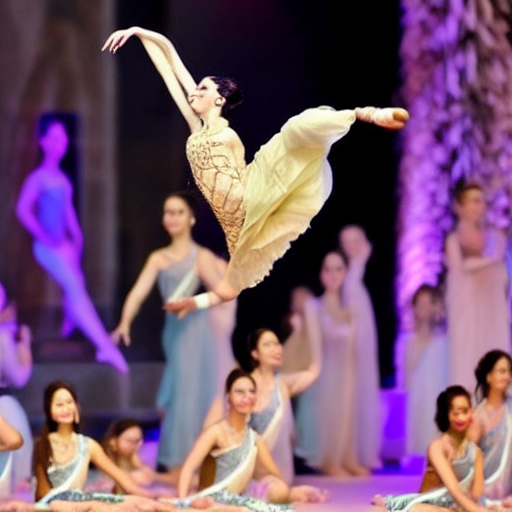

In [13]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed삽입
generator = torch.manual_seed(0)

prompt = "A graceful dancer mid-leap with limbs extended elegantly." 
negative_prompt = "A static, unengaging pose lacking dynamics."

images = openpose_image

# 이미지를 생성
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=1.2,
    num_inference_steps=20,
    guidance_scale=10.0,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 출력
openpose_image1

  0%|          | 0/50 [00:00<?, ?it/s]

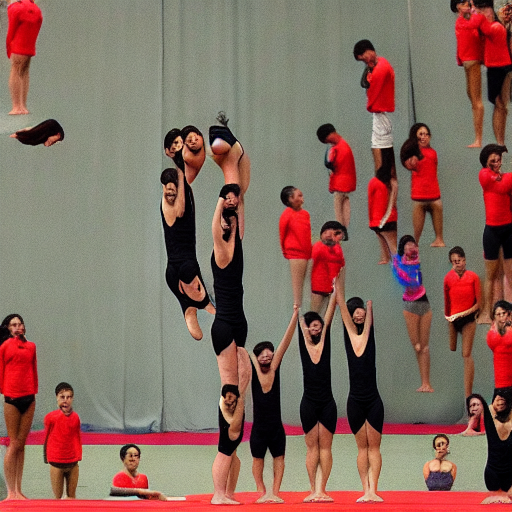

In [14]:
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

generator = torch.manual_seed(5)

prompt = "A poised gymnast holding a flawless handstand"
negative_prompt = "unengaging pose"

images = openpose_image

openpose_image2 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=2.8,
    num_inference_steps=50,
    guidance_scale=15.0,
    generator=generator,
    image=canny_image
).images[0]


openpose_image2

# 3. 윤곽선 검출 + 인체 자세 감지
- 2가지의 전처리기를 동시에 사용.
- 2개의 전처리기를 controlnets라는 리스트로 만들어서 파이프라인으로 전달. 

## 3.1 Canny 알고리즘을 사용한 윤곽선 검출
- Canny 알고리즘으로 윤곽선을 검출
- Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검출 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다.

In [15]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

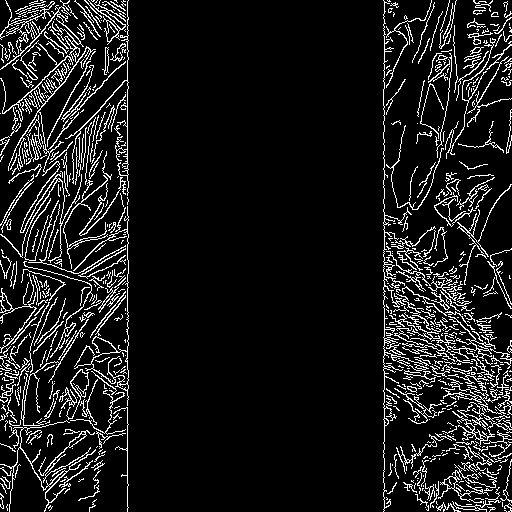

In [23]:
# 이미지
canny_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/compel-blend.png"
)

#threshhold를 지정
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분 삭제
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image.show()

## 3.2 Openpose를 사용한 인체 자세 검출
- human pose 검출

cuda


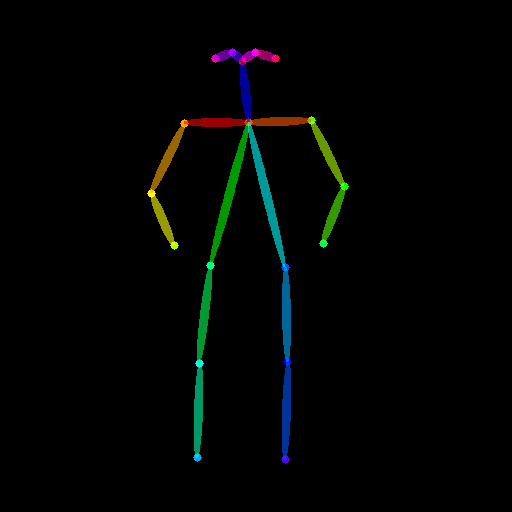

In [24]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# 이미지를 불러옵니다. 
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# OpenposeDetector를 사용하여 인체 자세를 검출
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

openpose_image.show()

- Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

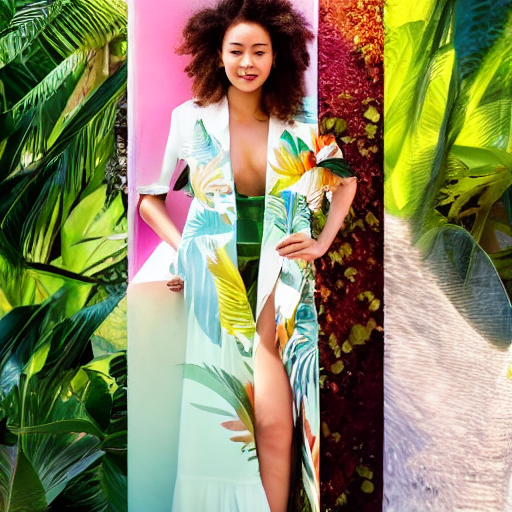

In [25]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 생성
controlnets = [ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16), ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)]

# controlnets를 파이프라인으로 전달
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
).to("cuda")

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성
prompt = "A lush, tropical paradise with vibrant flowers, dense foliage, and the warm sun casting dappled light through the leaves."
negative_prompt = "A barren, lifeless scene devoid of vibrant colors or lush vegetation."


# seed를 지정
generator = torch.Generator(device = "cuda").manual_seed(0)

images = [openpose_image, canny_image]

# 이미지를 생성
canny_openpose_image = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt).images[0]

# 생성된 이미지를 저장
canny_openpose_image.save("/aiffel/aiffel/canny_openpose_image.png")

# 생성된 이미지를 출력
canny_openpose_image.show()

# 4. 회고 및 참고자료
## 4.1 회고
- 원하는 배경 및 테마를 가진 사진을 생성하기는 쉬웠으나 명확한 특징이나 특정 사물이나 인물 자세를 자세하게 생성하는데는 프롬프트를 작성하는데 어렵다는 것을 알았다.
    - 사진들의 표정이나 자세가 다소 어색하게 나타났다.


## 4.2 참고자료
- GPT 프롬프트 생성
    - 귀걸이를 건 소녀사진에 어울리는 프롬프트 생성
    - human pose에 어울리는 프롬프트 생성
    - 트로피칼풍의 사진을 생성하기 위한 프롬프트 생성